In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras 
from keras.layers import Input, Dense, Dropout, LSTM
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

In [52]:
def rmse(pred, actual):
    error = np.subtract(pred, actual)
    sqerror= np.sum(np.square(error))/actual.shape[0]
    return np.sqrt(sqerror)

In [2]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, history, label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [4]:
df = pd.read_csv("../data/data_processed_cleaned.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')

df['fve'] = df['fve'] * 0.03
df['mve'] = df['mve'] * 0.07
df['wpg'] = df['wpg'] * 0.07

df['production_usage'] = df['fve'] + df['mve'] + df['wpg'] 
TRAIN_SPLIT = 29000

In [6]:
features_considered = ['price', 'isWeekend', 'isHoliday','temp', 'wind', 'day_cos', 'day_sin', 'month_cos', 'month_sin']
features = df[features_considered]
features.index = df['date']

prod_dataset = df['production_usage'].values
data_mean = prod_dataset.mean(axis=0)
data_std = prod_dataset.std(axis=0)
prod_dataset = (prod_dataset-data_mean)/data_std


cons_dataset = df['consumption_usage'].values
data_mean = cons_dataset.mean(axis=0)
data_std = cons_dataset.std(axis=0)
cons_dataset = (cons_dataset-data_mean)/data_std

dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

In [7]:
past_history = 96
future_target = 4
STEP = 1


x, y1 = multivariate_data(dataset, prod_dataset, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x, y2 = multivariate_data(dataset, cons_dataset, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val , y1_val = multivariate_data(dataset, prod_dataset,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
x_val , y2_val = multivariate_data(dataset, cons_dataset,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [48]:
# https://stackoverflow.com/questions/47596703/multiple-outputs-for-multi-step-ahead-time-series-prediction-with-keras-lstm

inputs = Input(shape=(past_history,len(features_considered))) 
m = LSTM(128,  return_sequences=True)(inputs)
#m = Dropout(0.2)(m)
m = LSTM(256)(m)
#m = Dropout(0.1)(m)
m = Dense(96, activation='tanh')(m)
m = Dropout(0.1)(m)
outputA = Dense(future_target, activation='tanh')(m)
outputB = Dense(future_target, activation='tanh')(m)

m = Model(inputs=[inputs], outputs=[outputA, outputB])
m.compile(optimizer='adam', loss='mse')


history = m.fit(x,[y1,y2], epochs=10,steps_per_epoch=100)

test_scores = m.evaluate(x_val, [y1_val, y2_val], verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/10
100/100 [==============================] - 9s 78ms/step - loss: 0.9488 - dense_26_loss: 0.5271 - dense_27_loss: 0.4216
Epoch 2/10
100/100 [==============================] - 7s 73ms/step - loss: 0.6467 - dense_26_loss: 0.3319 - dense_27_loss: 0.3148
Epoch 3/10
100/100 [==============================] - 7s 73ms/step - loss: 0.5403 - dense_26_loss: 0.2766 - dense_27_loss: 0.2636
Epoch 4/10
100/100 [==============================] - 7s 73ms/step - loss: 0.4643 - dense_26_loss: 0.2424 - dense_27_loss: 0.2219
Epoch 5/10
100/100 [==============================] - 7s 74ms/step - loss: 0.4145 - dense_26_loss: 0.2209 - dense_27_loss: 0.1937
Epoch 6/10
100/100 [==============================] - 7s 73ms/step - loss: 0.3678 - dense_26_loss: 0.2035 - dense_27_loss: 0.1643
Epoch 7/10
100/100 [==============================] - 7s 73ms/step - loss: 0.3536 - dense_26_loss: 0.1973 - dense_27_loss: 0.1563
Epoch 8/10
100/100 [==============================] - 7s 73ms/step - loss: 0.3448 - dense_

In [49]:
pred = m.predict(x_val)

In [66]:
actual = []
for index,val in enumerate(y1_val):
    actual.append([y1_val[index:index+4]])
actual = np.array(actual)

<ipython-input-66-8ffa35d5544e>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actual = np.array(actual)


In [76]:
rmse(pred[0][:-4],actual[:-4])

array([1.50154116, 1.50553882, 1.50979983, 1.5142872 ])

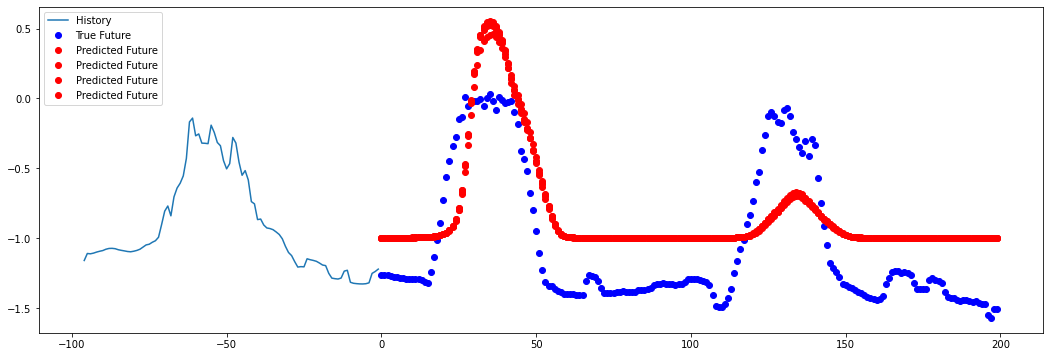

In [50]:
multi_step_plot(prod_dataset[TRAIN_SPLIT:][:96], y1_val[:200], pred[0][:200])

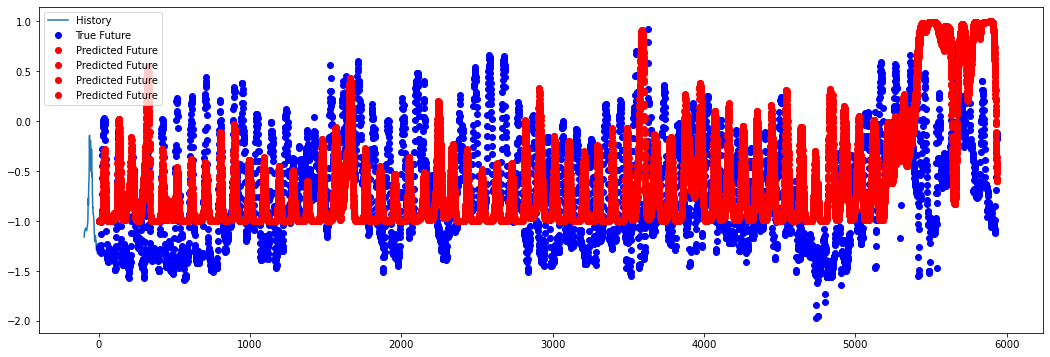

In [17]:
multi_step_plot(prod_dataset[TRAIN_SPLIT:][:96], y1_val, pred[0])

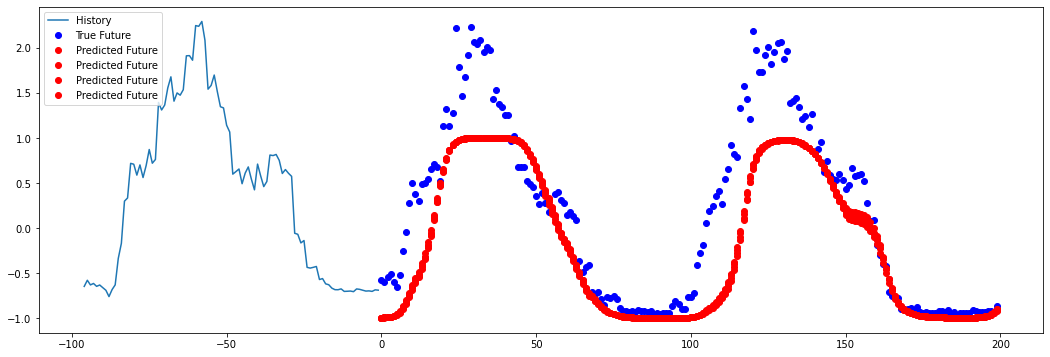

In [51]:
multi_step_plot(cons_dataset[TRAIN_SPLIT:][:96], y2_val[:200], pred[1][:200])

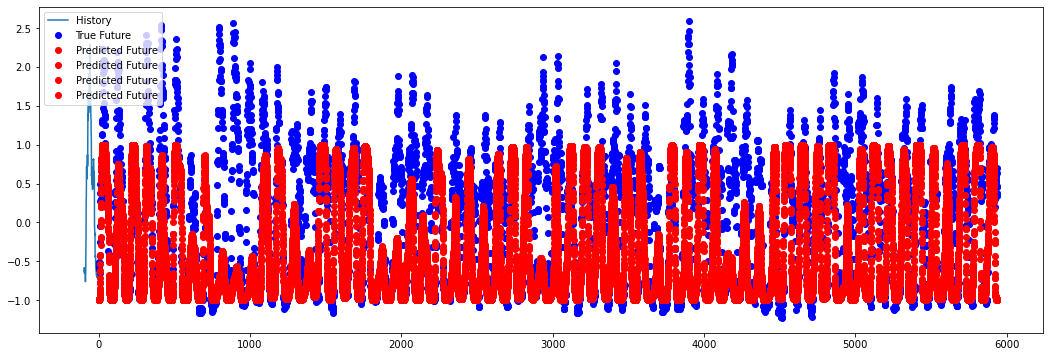

In [13]:
multi_step_plot(cons_dataset[TRAIN_SPLIT:][:96], y2_val, pred[1])